<h1><span style="color:blue">Handwritten digit classification using multivariate linear regression. </span></h1>
  Robert Martin
  July 3, 2020

In this notebook we develop a least squares model that will classify handwritten digits. This is a task more suited to convolutional neural networks. In fact such networks have been shown to have a 99% accuracy rate. Our aim is to demonstrate that this classification can be accomplished using a simple least squares model*. Also this exercise will afford us a better understanding of the least squares method of building models. We will demonstrate that an accuracy rate of near 90% can be achieved using this method.

More on terminology.

Simple linear regression involves finding a linear equation or linear regression model with a single independent variable and a single dependent variable. A multiple regression model is one that attempts to predict a dependent variable  based on the value of multiple independent variables. For example we could attempt to predict the selling price of a house based on the number of bedrooms and square footage of the house. This is an example of two independent variables. Multivariate or multi target regression is the term used when there are multiple dependent variables or outputs. For this exercise the set of dependent variables is the set of 284 pixel values for the digit image. There are 10 target variables, namely the 10 digits. As the target variables are categorical (is the image digit a given digit value, yes or no) we are performing multi-target classification here.



In [1]:
# Libraries

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina' 
import pandas as pd

<h2><span style="color:blue">Load the data </span></h2>

We use a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9 to train the model. A dataset of 10,000 images will be used in testing the model. The MNIST dataset is used.  https://en.wikipedia.org/wiki/MNIST_database

In [3]:
# load the data
#training_data = np.genfromtxt("../data/mnist_train.csv",delimiter=',')
#test_data = np.genfromtxt("../data/mnist_test.csv",delimiter=',')

In [3]:
pwd

'/Users/rmartin/Dropbox/MyPython/notebooks'

In [4]:
# load the data
training_df = pd.read_csv('mnist_train.csv.gz',header = None,compression='gzip')
test_df = pd.read_csv('mnist_test.csv.gz',header = None,compression='gzip')    
training_data = training_df.values
test_data = test_df.values

In [5]:
(training_data.shape , test_data.shape)

((60000, 785), (10000, 785))

We see above that training_data is a 60,000 x 785 matrix.  Each row has 784 pixel values for the image and one value for the label.  The labels are stored in the first entry of each row.  We unpack this data below.

In [6]:
# unpack the training images and symbols
Xtest, labelstest = (test_data[:,1:],test_data[:,0])
X , labels = (training_data[:,1:],training_data[:,0])
(X.shape,labels.shape)

((60000, 784), (60000,))

From above we see the matrix "X" contains 60,000 images of (784 = 28 x 28) pixels. The array, "labels" contains the 60,000 labels or target values for each image.</br>
Let us display the digit corresponding row 5 in X.

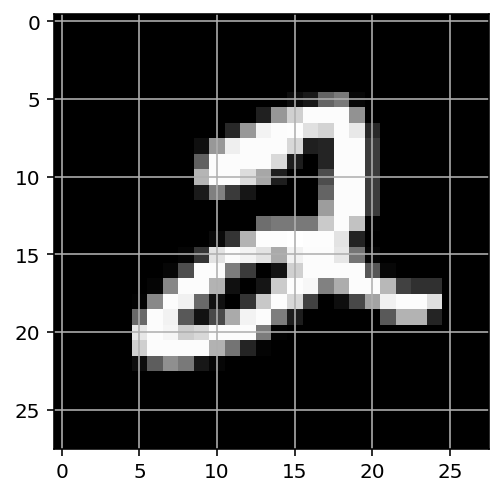

In [7]:
digit = X[5].reshape(28,28)
plt.imshow(digit,cmap='gray')
plt.grid()

In [8]:
# We see the digit "2" let us check the label and see if it matches the image
print(labels[5])  # yes it does see the "2" below

2


The linear regression model is shown below.  $X$ is the design matrix. The rows of $X$ are our inputs or "feature vectors". $\vec{\mathbf{\beta}}$ is the parameter vector, what we are solving for. $\vec{\mathbf{y}}$ is the observation vector containing the labels for each input

\begin{align}
X  \vec{\mathbf{\beta}}  = \vec{\mathbf{y}}   \\  
\end{align}

This system is overdetermined containing 60,000 equation and 785 unknown parameters. We will solve by using the standard normal equations used in least squares.

\begin{align}
\vec{\mathbf{\beta}}  =   (X^T X)^{-1} X^T  \vec{\mathbf{y}} \\   
\end{align}


The vector of observations $\vec{\mathbf{y}}$ contains digit values 0 through 9.  The model will have difficuly predicting these values as is.  Instead imagine for a moment that we are just trying to determine if a digit is a zero or not. So we reduce our problem to a simpler problem. Just determine if the digit is a zero.  To do this we change our labele to y = 0 if the digit is not a zero and y = 1 if the digit is a zero. The numpy command below will create the new y.

In [9]:
y = np.where(labels==0,1,0) # this command looks "where" the labels values are 0 and replacese with a 1 else replace with a 0.
print(f'First 10 label values are {labels[:10]}')
print(f'First 10 y values are {y[:10]}')
# see the comparison of the original vector of labels and y. The second label is a zero so we see a 1 in 
# corresponding postion for y

First 10 label values are [5 0 4 1 9 2 1 3 1 4]
First 10 y values are [0 1 0 0 0 0 0 0 0 0]


In [10]:
# We need to append a column of zeros to the design matrix X
X = np.hstack((X,np.ones((60000,1))))

In [11]:
# compute the parameters for the model, again we are only detecting digit zero for now
# this involves solving a sytem of 60,000 equations and 785 unknowns
beta = np.linalg.pinv(X.T@X)@X.T@y
beta.shape

(785,)

<h2><span style="color:blue">Test the zero digit detector. </span></h2>

In [12]:
# Get 100 random digits from the test set
index_values = np.random.choice(range(10000),100,replace=False)
digits = Xtest[index_values]
# append column of 1's
digits = np.hstack((digits,np.ones((100,1))))
# predict output for these digits
predict_values =(digits @ beta).round()


In [13]:
# which digits do we predict are zero, below will give the position of the zeros. Out of the list of 100 numbers 7 were zero.
np.where(predict_values==1)

(array([16, 20, 27, 40, 63, 76, 80]),)

In [14]:
# Which digits are zero, below will give the position of the zeros. Comparing below to above we see 100% accuracy.  
# Not a big deal as we were just testing between two possiblities. Is the digit zero or not.
np.where(labelstest[index_values]==0)

(array([16, 20, 27, 40, 60, 63, 76, 78, 80]),)

<h2><span style="color:blue">Ten digit classification. </span></h2>

To accomplish 10 digit classification we combine 10 linear regressors, each similar to the on above, in parallel. This will involve using one-hot-encoding for our labels. Each label instead of being represented as a single digit will be represented by an array of 10 bits all zero value excecpt a "1" in the position corresponding to the digit value.  For example the digit 3 will be encoded [0,0,0,1,0,0,0,0,0,0]. We start counting from zero. When predicting a digit value the model will output a 10 bit string.  The postion that has the largest value is the predicted digit.
For example if the mode output the array [.22,.01,1.2,.44,.10,.25,.45,.76,.30,.55] then we predict the digit is a "2". Our parameter vector $\vec{\mathbf{\beta}}$ will not be a matrix of size 785 x 10.


In [15]:
# one hot encode the labels
labels = labels.astype(int)
y = np.zeros((60000,10))
for k in range(60000):
    y[k,labels[k]]=1

In [16]:
# display the first 10 labels
y[:10,:]
# below we see the first label is a digit "5"
# for the zero digit detector we just used the first column below. Now we process all 10 columns in parallel

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

<h2><span style="color:blue">Compute the parameter matrix $\vec{\mathbf{\beta}}$ </span></h2>

In [17]:
beta_matrix = np.linalg.pinv(X.T@X)@X.T@y

We have just solve a sytem of 60000 equations in 785 unknowns.  Actually we have simultaneously solved 10 such systems.

In [18]:
beta_matrix.shape

(785, 10)

<h2><span style="color:blue">Test the model with 100 random digits. </span></h2>

In [19]:
# predict output for the random digits chosen above
predict_values =(digits @ beta_matrix)

In [20]:
predict_values.shape

(100, 10)

In [21]:
outcomes = np.argmax(predict_values,axis=1)
outcomes[:20]
# below we see the prediction for the first 20 digits

array([9, 3, 1, 6, 3, 9, 9, 9, 7, 9, 4, 8, 3, 6, 1, 6, 0, 3, 4, 8])

In [22]:
print('     ',labelstest[index_values][:20])

      [9 3 1 6 3 9 9 4 7 9 4 8 3 6 1 6 0 3 4 8]


Compute the accuracy.  Several runs give an average accuracy between 85 - 90 %

In [23]:
sum(outcomes==labelstest[index_values])/100

0.84

In [24]:
# save the parameter matrix for later use
np.save("beta_matrix.npy",beta_matrix)

In [27]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p pandas,numpy,matplotlib,watermark 

# date
print (" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.6
IPython 7.12.0

pandas 1.0.1
numpy 1.15.0
matplotlib 3.1.3
watermark 2.0.2

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
 
last updated: Thu Jul 09 2020 11:01:36 EDT
